# Convolutional Codes

This turbo package contains a number of classes and functions for dealing with turbo and convolutional codes. First we import the necessary classes for convolutional codes.

In [2]:
%matplotlib inline

from ConvTrellisDef import ConvTrellisDef
from Trellis import Trellis
from ConvEncoder import ConvEncoder
from ViterbiDecoder import ViterbiDecoder


## Defining a code

Let us define a r=1/3 rate convolutional code with the polynmals $1 +D^{2}$, $1 + D + D^{2}$ and $1 + D$. Next we instantiate the trellis object as well as the convolutionl encoder and viterbi decoder objects. 

In [3]:
gen_poly = [[1, 0, 1], [1, 1, 1], [1, 1, 0]]
trellis = Trellis(ConvTrellisDef(gen_poly, []))
convenc = ConvEncoder(trellis)
viterbi = ViterbiDecoder(trellis)


## Encoding and Decoding

Let us encode a message (`data_rx`) with the code defined above.

In [4]:
data_tx = [1, 0, 0, 1]
encoded_tx = convenc.encode(data_tx)
print('encoded = ' + str(encoded_tx) + ', len(encoded)= ' + str(len(encoded_tx)))

encoded = [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0], len(encoded)= 18


The encoded stream is more than 3 times longer than the data due to zero termination. Now that the data is encoded we simulate transmission over a noisy channel. This is done by flipping some of the bits.

In [5]:
encoded_rx = list(encoded_tx)
for b in [0, 1, 6]:
    encoded_rx[b] = int(not (encoded_tx[b]))
print('encoded_rx = ' + str(encoded_rx))
encoded_rx_llr = [2*x-1 for x in encoded_rx]

encoded_rx = [0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]


We use the viterbi decoder to try to decode the originial message from the received stream.

In [6]:
data_rx = viterbi.decode(encoded_rx_llr, len(data_tx)+ trellis.tdef.K - 1)
data_rx = convenc.remove_zero_termination(data_rx)
print(data_rx)


[1, 0, 0, 1]


Voila, the original messge is recovered despite the introduced errors on the channel. The same result can be achieved by using even another class of the package. A soft-input-soft-output (SISO) decoder which is also implemented. This type of decoder does not only output the decoded bits but also their reliablilty. Let us apply the decoder and inspect its output. We decode both the original transmitted stream as well as the received noisy stream.  

In [7]:
from SisoDecoder import SisoDecoder

convsiso = SisoDecoder(trellis)
convsiso.backward_init = True
n_stages = len(data_tx) + trellis.tdef.K - 1
zero = [0] * n_stages  # no extrinsic and apriori information is available
data_r1, _ = convsiso.decode(zero, encoded_tx, n_stages)  # decode stream without bit flips
data_r1 = convenc.remove_zero_termination(data_r1)
print('Decoded data without noise: ' + str(data_r1))
data_r2, _ = convsiso.decode(zero, encoded_rx_llr, n_stages)  # decode stream with bit flips
data_r2 = convenc.remove_zero_termination(data_r2)
print('Decoded data with noise: ' + str(data_r2))


Decoded data without noise: [6, -5, -5, 6]
Decoded data with noise: [1, -2, -5, 5]


The output of the SISO decoder is a log likeliood (LLR) value for each bit. A value > 0 indicateds a binary `1` whereas a value < 0 indicates a binary `0`. The magnitude represents the reliability of the estimation. We can see that in both cases the correct data is decoded. In the second case the magnitudes are in general smaller. This is becauses the decoder is 'less certain' about the result due to the introduced errors. Note that in this example all values were integer but in general the inputs and outputs of the SISO decoder can be floating point numbers.

## Performance

We like to measure the performance of the code in terms of bit error rate. For this purpose there exists the example script `ViterbiTest.py`. It performs a monte-carlo simulation of a BSPK AWGN channel for different signal-to-noise ratios. A code with r=1/2 and constraint length K=3 is used. Let us run the script.

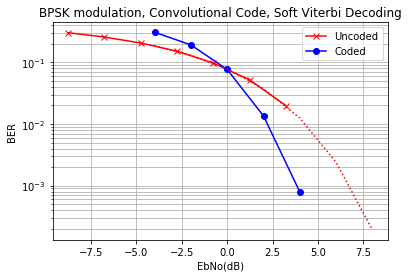

In [8]:
import ViterbiTest
ViterbiTest.main(100000, False)

# Turbo Codes


Also for turbo codes a set of classes is available. The script `TurboTest.py` performs a bit error rate simulation. Let us run the script.

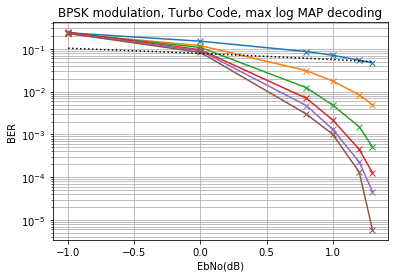

In [9]:
import TurboTest
block_size = 512
n_blocks = 2000
TurboTest.main(block_size, n_blocks, False)

The script simulates a turbo code with rate r=1/3, a block size of 512 bits and a qpp interleaver in an AWGN channel and BPSK modulation. The bit error rates of iterations 1-6 are plotted.